In [1]:
# default_exp bgseg_unet_training

In [1]:
from facelib.bgseg_dataset_coco import out_path_lbl as path_lbl, out_path_img as path_img
path_lbl, path_img

(PosixPath('../data/seg/coco/labels'), PosixPath('../data/seg/coco/images'))

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
from pathlib import PosixPath

In [3]:
fnames = get_image_files(path_img)
fnames[:3], len(fnames)

([PosixPath('../data/seg/coco/images/000000395203.jpg'),
  PosixPath('../data/seg/coco/images/000000118447.jpg'),
  PosixPath('../data/seg/coco/images/000000196483.jpg')],
 8764)

In [4]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('../data/seg/coco/labels/000000536743.png'),
 PosixPath('../data/seg/coco/labels/000000265810.png'),
 PosixPath('../data/seg/coco/labels/000000004134.png')]

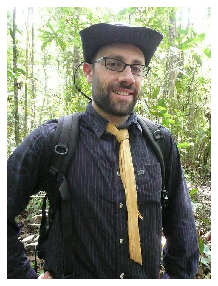

In [5]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [6]:
get_y_fn = lambda x: path_lbl/f'{x.stem}.png'

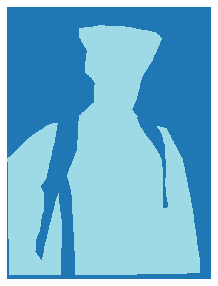

In [7]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [8]:
src_size = np.array(mask.shape[1:])
src_size,mask.data.unique()

(array([640, 480]), tensor([0, 1]))

In [9]:
src_size = np.array([512, 512])

In [10]:
codes = ['bg', 'person']

In [11]:
len(codes)

2

In [12]:
train_transforms = [
#     dihedral_affine(),
    rotate(degrees=(-45, 45), p=0.5),
    symmetric_warp(magnitude=(-0.3, 0.3), p=0.6),
    rand_zoom(scale=(1.,2.), p=0.8),
    brightness(change=(0.3, 0.7), p=0.6),
    contrast(scale=(0.7,1.3), p=0.6),
    rand_crop(padding_mode='zeros')
]
valid_transforms = [
    brightness(change=(0.3, 0.7), p=0.01),
]

custom_transforms = (train_transforms,valid_transforms)

In [13]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct(0.1)
       .label_from_func(get_y_fn, classes=codes))

def create_data(size=[720,960], bs=4, transforms=custom_transforms):
    data = (src
           .transform(transforms, size=size, tfm_y=True)
           .databunch(bs=bs)
           .normalize(imagenet_stats)
          )
    return data

In [14]:
size = src_size//8
data = create_data(size, bs=8)
size

array([64, 64])

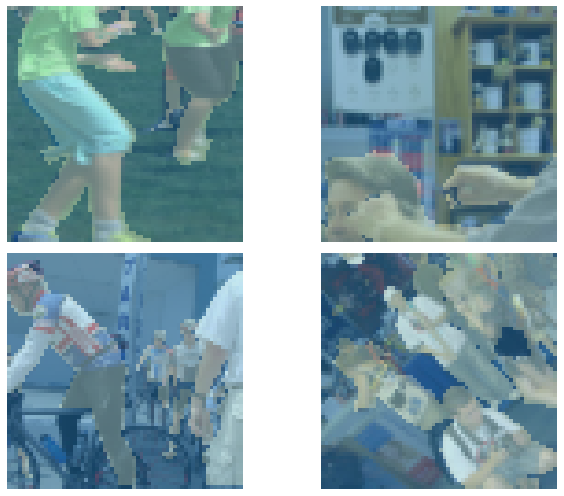

In [15]:
data.show_batch(2, figsize=(10,7))

In [16]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['bg']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [17]:
def save_learner(learn, name):
    learn.path = PosixPath('../models/')
    learn.metrics = []
    learn.export(name)
    learn.path = path_img
    learn.metrics = [acc_camvid]
    
def load_my_learner(name):
    learn = load_learner('../models/', file=name)
    learn.metrics = [acc_camvid]
    learn.path = path_img
    return learn

In [18]:
def save_torch_inference(model, path):
    torch.save(model.state_dict(), path)
    
def load_torch_inference(model, path, device=torch.device('cpu')):
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()

In [19]:
size = src_size//8
data = create_data(size, bs=8)

In [73]:
learn = unet_learner(data, models.resnet18, metrics=[acc_camvid], wd=1e-3)
learn.callbacks.append(ShowGraph(learn))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


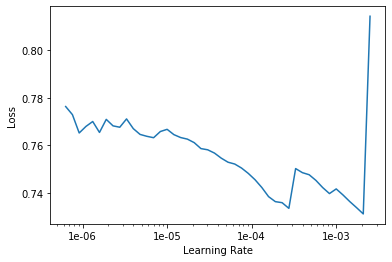

In [74]:
lr_find(learn)
learn.recorder.plot()

epoch,train_loss,valid_loss,acc_camvid,time
0,0.470070,0.440681,0.792102,00:31
1,0.458527,0.389867,0.856269,00:31
2,0.435582,0.393827,0.845294,00:31
3,0.404777,0.367226,0.848728,00:31
4,0.397533,0.350717,0.846094,00:31
5,0.380398,0.340639,0.868756,00:31
6,0.386265,0.330466,0.887327,00:32
7,0.353582,0.326215,0.896786,00:32
8,0.359162,0.321573,0.877049,00:32
9,0.352037,0.322475,0.882081,00:31


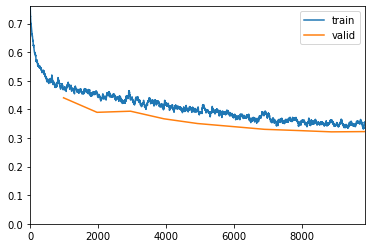

In [75]:
learn.fit_one_cycle(10, 1e-3)

In [76]:
save_learner(learn, 'bgseg_unet1.pkl')

In [77]:
size = src_size//4
learn.data = create_data(size, bs=8)

In [78]:
learn = load_my_learner('bgseg_unet1.pkl')
learn.data = data

epoch,train_loss,valid_loss,acc_camvid,time
0,0.320440,0.279907,0.887182,01:13
1,0.332776,0.294091,0.935896,01:11
2,0.327820,0.293664,0.944632,01:11
3,0.321968,0.287606,0.936317,01:11
4,0.292141,0.257597,0.910513,01:11
5,0.297212,0.257026,0.920483,01:11
6,0.279740,0.260781,0.937072,01:11
7,0.278697,0.245415,0.917714,01:11
8,0.264105,0.243019,0.920578,01:11
9,0.274075,0.429604,0.917235,01:11


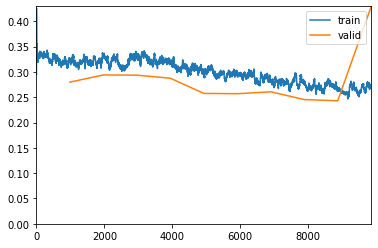

In [79]:
learn.fit_one_cycle(10, 1e-3)

In [81]:
save_learner(learn, 'bgseg_unet2.pkl')

In [83]:
size = src_size//2
learn.data = create_data(size, bs=4)

In [84]:
learn = load_my_learner('bgseg_unet2.pkl')
learn.data = data

epoch,train_loss,valid_loss,acc_camvid,time
0,0.291174,0.243053,0.896328,04:08
1,0.284659,0.238644,0.919304,04:05
2,0.282262,0.231680,0.943752,04:05
3,0.255011,0.216465,0.928449,04:05
4,0.246419,0.213781,0.927525,04:05


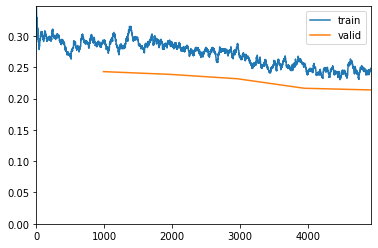

In [86]:
learn.fit_one_cycle(5, 1e-3)

In [90]:
save_learner(learn, 'bgseg_unet3.pkl')

In [27]:
size = src_size
data = create_data(size, bs=4)

In [28]:
learn = load_my_learner('bgseg_unet3.pkl')
learn.data = data

In [21]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.327589,0.233000,0.898400,15:47
1,0.318164,0.223843,0.928300,15:49
2,0.296917,0.239165,0.904440,15:49
3,0.294412,0.224461,0.939930,15:49
4,0.283598,0.222734,0.926411,15:49
5,0.291051,0.214506,0.915786,15:49
6,0.285358,0.213339,0.939791,15:49
7,0.246783,0.206854,0.927984,15:49
8,0.251508,0.204202,0.932120,15:50
9,0.244519,0.204447,0.926753,15:50


In [22]:
save_learner(learn, 'bgseg_unet4.pkl')

In [19]:
size = src_size
data = create_data(size, bs=4)

In [20]:
learn = load_my_learner('bgseg_unet4.pkl')
learn.data = data

epoch,train_loss,valid_loss,acc_camvid,time
0,0.343420,0.249244,0.926446,16:27
1,0.424705,0.331443,0.880772,16:30


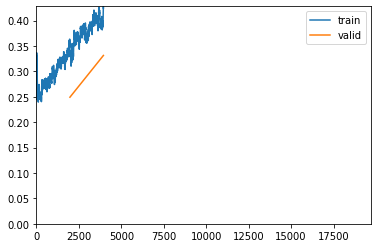

In [ ]:
learn.unfreeze()
learn.wd = 1e-2
learn.fit_one_cycle(10, slice(1e-3))

In [ ]:
save_learner(learn, 'bgseg_unet5.pkl')

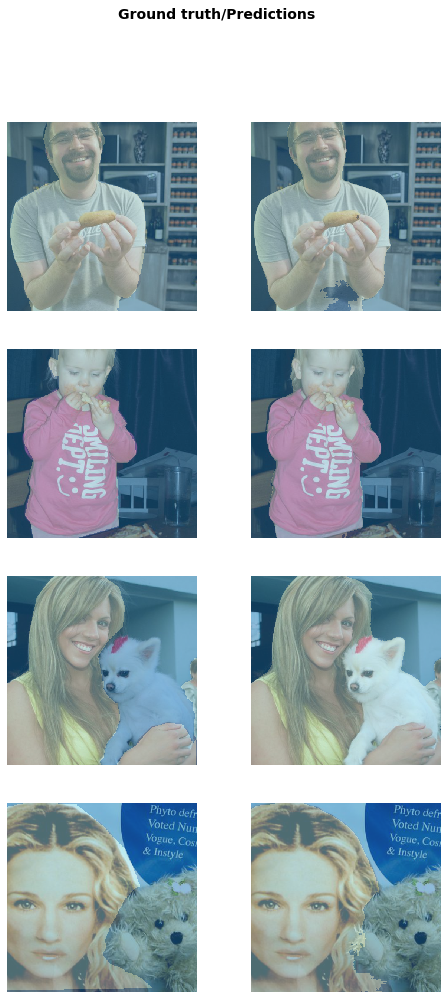

In [22]:
learn.show_results()

### Convert images to masks

In [20]:
import cv2
from facelib.face_dataset_unlabeled import create_df as create_unlabeled_df

In [21]:
df = create_unlabeled_df()
df.head()

,image_path,valid,dataset
0,/data/faces/unlabeled/images/sof_1.jpg,False,unlabeled
1,/data/faces/unlabeled/images/sof_724.jpg,False,unlabeled
2,/data/faces/unlabeled/images/sof_404.jpg,False,unlabeled
3,/data/faces/unlabeled/images/sof_1277.jpg,False,unlabeled
4,/data/faces/unlabeled/images/sof_2491.jpg,False,unlabeled


In [22]:
defaults.device = torch.device('cuda')
learn = load_my_learner('bgseg_unet4.pkl')
# learn = load_learner('../models/', file='bgseg_unet.pkl')
# _ = learn.model.to('cpu')

In [23]:
def im2mask(im):
    orig_shape = im.shape
    im = tensor(im[:,:,[2,1,0]]) #.to('cuda')

    im_res = F.interpolate(im.permute(2,0,1)[None].float(), size=(480,640))[0] / 255.
    image_res = Image(im_res)

    seg, *o = learn.predict(image_res)
    # mask = seg.data.float() # (only 0 or 1)
    mask = o[1][1][None] # [1,480,640]
    resize_one_img = lambda x, size: F.interpolate(x[None], size=size, mode='bilinear', align_corners=True)[0]
    mask = resize_one_img(mask.float(), orig_shape[:2])
    return Image(mask)

In [69]:
OUT_MASK_DIR = Path('../data/seg/unlabeled/')
IN_IMG_DIR = Path('/data/faces/unlabeled/images/')
def convert():
#     im_paths = get_image_files(IN_IMG_DIR)
    im_paths = list(df['image_path'])
    print('num images:', len(im_paths))
    for im_path in progress_bar(im_paths):
        im_name = Path(im_path).stem + '.png'
        im = cv2.imread(im_path)
        im2mask(im).save(OUT_MASK_DIR/im_name)
convert()

num images: 86130


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [64]:
im_paths = list(df['image_path'])
im_paths[:10]

['/data/faces/unlabeled/images/sof_1.jpg',
 '/data/faces/unlabeled/images/sof_724.jpg',
 '/data/faces/unlabeled/images/sof_404.jpg',
 '/data/faces/unlabeled/images/sof_1277.jpg',
 '/data/faces/unlabeled/images/sof_2491.jpg',
 '/data/faces/unlabeled/images/sof_1276.jpg',
 '/data/faces/unlabeled/images/sof_0.jpg',
 '/data/faces/unlabeled/images/sof_1897.jpg',
 '/data/faces/unlabeled/images/sof_10.jpg',
 '/data/faces/unlabeled/images/sof_725.jpg']

In [63]:
cv2.imread(str(IN_IMG_DIR/'fc_53099.png'))

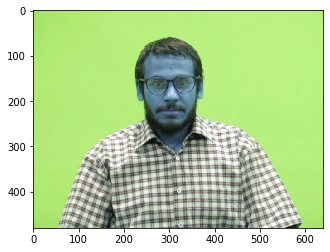

In [65]:
plot(cv2.imread(str(IN_IMG_DIR/'sof_1.jpg')))

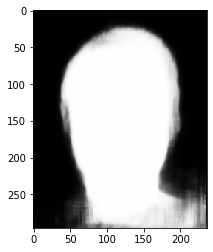

In [67]:
plot(cv2.imread(str(OUT_MASK_DIR/'sof_1.png')))

(296, 236, 3) torch.Size([1, 296, 236])


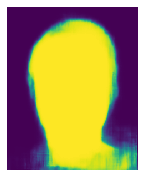

In [40]:
im = cv2.imread('../test_data/Face629.jpg')
im2mask(im).save('../test_data/temp.jpg')
im2mask(im).show()
print(im.shape, im2mask(im).shape)

### Examples

In [24]:
learn = load_learner('../models/', file='bgseg_unet.pkl')

In [25]:
import cv2

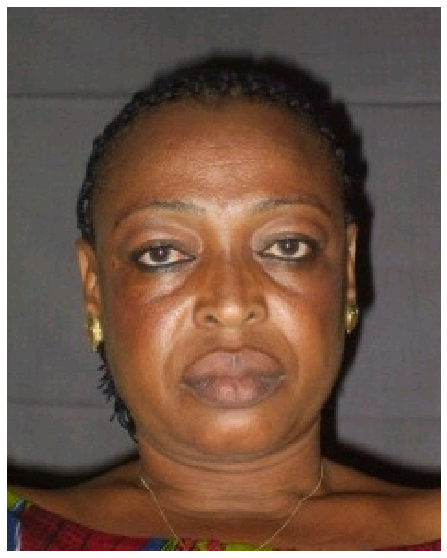

In [26]:
# im = cv2.imread('../test_data/newfam.jpg')
im = cv2.imread('../test_data/Face629.jpg')
im = im[:,:,[2,1,0]]
image = Image(tensor(im).permute(2,0,1).float() / 255.)
image.show(figsize=(10,10))

torch.Size([1, 384, 384])


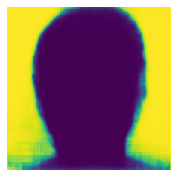

In [34]:
seg, *o = learn.predict(image)
print(seg.data.shape)
Image(o[1][0][None]).show()